# Service Optimization: Drayage at a Marine Terminal

### Mitigating Supply Chain Volatility with FLOW
#### *FLOW 2023 Fall Technical Meeting*

Tom Vu, Thomas Koch, Elenna Dugundji


In [11]:
!pip install simpy

### Simulation

In [12]:
"""
Drayage example.

Important concepts:

1. Stochastic arrival
2. Limited shared resources
3. Waiting for other processes
4. Queue prioritization
5. Discrete event simulation

Scenario:
  - Containers arrive at the terminal on ships at a stochastic time interval and get
  offloaded onto stacks in the marine terminal container yard.
  - A terminal has a limited number of port assets to load containers onto chassis
  and defines an appointment queue for containers to be picked up at the terminal
  by a drayage provider.
  - When a drayage slot is available, the terminal starts the drayage process by
  loading a container onto a chassis and waits for the port asset to finish.
  - Otherwise if there is no drayage slot available, the containers wait in queue.
  - Demurrage costs are paid to the marine terminal operator if a container is not
  picked up by the drayage provider within 7 days.
  - To maximize utilization while avoiding demurrage, the drayage provider experiments
  with diversifying service: a premium high priority service for containers moved out 
  of the port within 3 days, and a standard service for containers moved within 7 days.

What is the optimal mixture of 3-day pickup to sell and 7-day pickup to sell?

  

"""
import random

import simpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RANDOM_SEED = 42
SIM_TIME = 1440 * 100     # Simulation time in minutes (100 days)
T_INTER_MAX = 12500       # A ship arrives randomly between 0 and T_INTER_MAX minutes (8-9 days)
MEAN_SHIP_SIZE = 5000     # Mean number of containers on a ship
NUM_MACHINES = 12         # Number of available port assets to load containers onto chassis
TIME_TO_DRAYAGE = 10      # Minutes it takes to load a container on a chassis
PRIORITY_FRAC = 0.2       # Fraction of containers that are marked as high priority.

class Drayage(object):
    """A marine terminal has a limited number of port assets (``num_machines``) available to
    load containers onto chassis in parallel.

    Drayage providers have to request an appointment in order to pick up a container at the port.
    When they get one, they can start the drayage processes and wait for the port asset to finish
    loading the container onto a chassis. This process takes ``time_to_drayage`` minutes.

    """
    def __init__(self, env, num_machines, time_to_drayage):
        self.env = env
        self.machine = simpy.PriorityResource(env, num_machines)
        self.time_to_drayage = time_to_drayage

    def process(self, container):
        """The loading process takes a ``container`` and loads it onto a chassis"""
        yield self.env.timeout(self.time_to_drayage)
        #print("%s processed." % (container))


def container(env, name, terminal, priority_frac):
    """The container arrival process (each container has a ``name``) begins after a ship arrives
    at the terminal (``terminal``), the container is off-loaded to the terminal container yard
    and the terminal announces the container is entered into the drayage appointment queue.

    The container waits in the appointment queue to be picked up and start the drayage,
    waits to finish being loaded onto a chassis and leaves the port.
    """

    # Record the time when the container arrives
    arrival_time = env.now
    # Determine whether the container has higher priority (20% chance)
    is_high_priority = random.random() <= priority_frac
    if is_high_priority:
      deadline = arrival_time + 3 * 24 * 60
    else:
      deadline = arrival_time + 7 * 24 * 60

    #print('%s arrives at the terminal at %.2f.' % (name, env.now))
    with terminal.machine.request(priority= deadline) as request:
        # Record the time when the container enters the queue
        queue_enter_time = env.now

        yield request

        # Record the time when the container starts processing
        start_time = env.now

        # Record the queue size when a container arrives at the terminal
        env._queue_sizes.append((env.now, len(terminal.machine.queue)))
        #print('%s enters the terminal at %.2f.' % (name, env.now))
        yield env.process(terminal.process(name))

        # Record the queue size when a container finishes processing
        env._queue_sizes.append((env.now, len(terminal.machine.queue)))
        #print('%s leaves the terminal at %.2f.' % (name, env.now))
        # Calculate the total time spent in the queue
        end_time = env.now
        queue_wait_time = start_time - queue_enter_time
        env._queue_wait_times.append(queue_wait_time)
        env._queue_wait_times_2.append((is_high_priority, priority_frac, queue_wait_time))


def setup(env, num_machines, time_to_drayage, t_inter_max, priority_frac):
    """Create a container terminal, a number of initial containers and keep creating ships
    approx. every ``t_inter`` minutes."""
    # Create the Drayage provider
    drayage = Drayage(env, num_machines, time_to_drayage)

    # Create initial terminal occupancy
    env._ship_arrivals.append(0)
    for i in range(random.randint(int(MEAN_SHIP_SIZE*0.8), int(MEAN_SHIP_SIZE*1.5))):
        i += 1
        env.process(container(env, 'Container %d' % i, drayage, priority_frac))

    # Create more ships while the simulation is running
    while True:
        yield env.timeout(random.randint(0, t_inter_max))
        i += 1
        env._ship_arrivals.append(env.now)
        ships_on_container = random.randint(int(MEAN_SHIP_SIZE*0.9), int(MEAN_SHIP_SIZE*1.3))
        print (f"Ship arrived with {ships_on_container} containers at t={env.now}. Qsize {env._queue_sizes[-1][1]}")
        for _ in range(ships_on_container): #Unload all containers from the ship
          env.process(container(env, 'Container %d' % i, drayage, priority_frac))


# Setup and start the simulation
random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_MACHINES, TIME_TO_DRAYAGE, T_INTER_MAX, PRIORITY_FRAC))

# Create a list to store container queue wait time and queue sizes.
env._queue_sizes = []
env._queue_wait_times = []
env._queue_wait_times_2 = []
env._ship_arrivals = []

# Execute!
env.run(until=SIM_TIME)

Ship arrived with 4553 containers at t=1824. Qsize 4423
Ship arrived with 4925 containers at t=6481. Qsize 3384
Ship arrived with 5401 containers at t=18736. Qsize 0
Ship arrived with 4808 containers at t=27040. Qsize 0
Ship arrived with 4845 containers at t=29141. Qsize 2276
Ship arrived with 4631 containers at t=31145. Qsize 4721
Ship arrived with 6034 containers at t=34483. Qsize 5344
Ship arrived with 5997 containers at t=39488. Qsize 5378
Ship arrived with 5483 containers at t=49850. Qsize 0
Ship arrived with 5347 containers at t=55372. Qsize 0
Ship arrived with 4806 containers at t=61035. Qsize 0
Ship arrived with 5064 containers at t=70147. Qsize 0
Ship arrived with 4850 containers at t=81875. Qsize 0
Ship arrived with 6002 containers at t=92083. Qsize 0
Ship arrived with 5217 containers at t=102287. Qsize 0
Ship arrived with 5365 containers at t=112856. Qsize 0
Ship arrived with 5817 containers at t=123117. Qsize 0
Ship arrived with 6259 containers at t=125452. Qsize 3009
Ship 

### Results

In [13]:
#Create data frame of stored queue size measurements.
df_queue_sizes = pd.DataFrame(env._queue_sizes,columns=['t','queue_size']).drop_duplicates()
df_queue_sizes['day'] = df_queue_sizes['t'] / (24*60)
df_queue_sizes = df_queue_sizes.set_index('day')

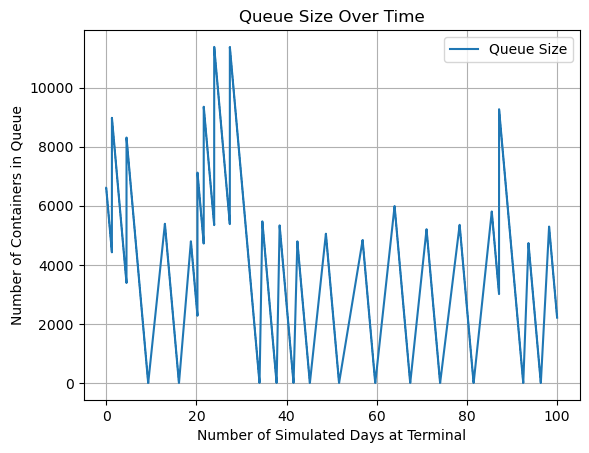

In [14]:
# Plot the queue size data
plt.figure()
plt.plot(df_queue_sizes.queue_size, label='Queue Size')
plt.xlabel('Number of Simulated Days at Terminal')
plt.ylabel('Number of Containers in Queue')
plt.title('Queue Size Over Time')
plt.legend()
plt.grid(True)
plt.show()

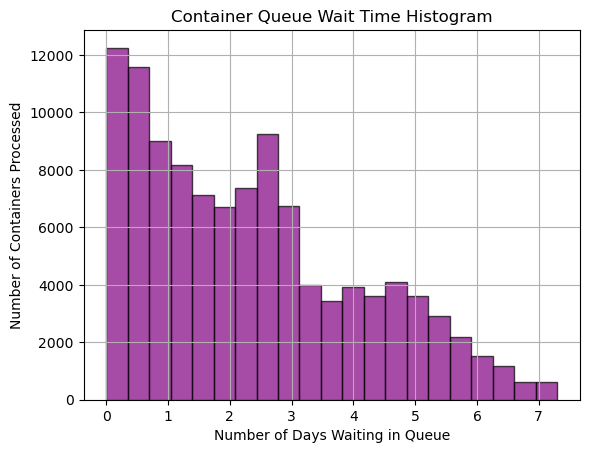

In [15]:
# Plot the queue wait time histogram
plt.figure()
bins = np.linspace(0, df.wait_time_days.max(), num=int(df.wait_time_days.max()*3)+1)
plt.hist(np.array(env._queue_wait_times) / (24 * 60), bins=bins, edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('Number of Days Waiting in Queue')
plt.ylabel('Number of Containers Processed')
plt.title('Container Queue Wait Time Histogram')
plt.grid(True)
plt.show()


In [16]:
df = pd.DataFrame(env._queue_wait_times_2,columns=['priority','priority_fraction','wait_time'])

#Calculate the wait time in days
df['wait_time_days'] = (df.wait_time / (24 * 60))

#Add column with percentage of high priority containers.
df['perc_high_priority'] = (df['priority_fraction'] * 100).astype('int')


#Calculate the number of days late beyond 5 or 7 days.
df['days_late5'] = (df.wait_time_days - 5).clip(lower=0)
df['days_late7'] = (df.wait_time_days - 7).clip(lower=0)

#Calculate the number of days late for priority and non piority containers
df.loc[df.priority, 'days_late_prio'] = (df.wait_time_days - 3).clip(lower=0)
df.loc[~df.priority, 'days_late_nonprio'] = (df.wait_time_days - 5).clip(lower=0)

#Mark whether containers were processed on time.
df.loc[df.priority, 'ontime'] = (df.wait_time_days <= 3)
df.loc[~df.priority, 'ontime'] = (df.wait_time_days <= 7)
#Mark days late whether non prio or prio.
df["days_late"] = df["days_late_prio"].combine_first(df["days_late_nonprio"])

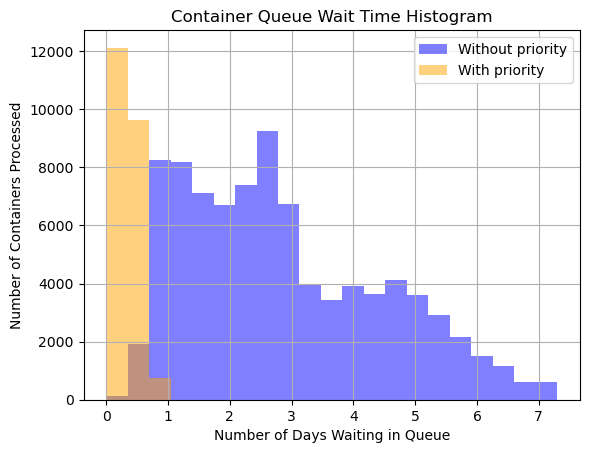

In [17]:
# Create a figure and axis
fig, ax = plt.subplots()

bins = np.linspace(0, df.wait_time_days.max(), num=int(df.wait_time_days.max()*3)+1)

# Plot the first histogram
df[~df.priority].wait_time_days.hist(alpha=0.5, label='Without priority',bins=bins, color='blue')

# Plot the second histogram
df[df.priority].wait_time_days.hist(alpha=0.5, label='With priority',bins=bins, color='orange')

# Add labels, a legend, and a title
plt.xlabel('Number of Days Waiting in Queue')
plt.ylabel('Number of Containers Processed')
plt.legend()
plt.title('Container Queue Wait Time Histogram')

# Show the plot
plt.show()